In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ,Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize


In [2]:
qr = QuantumRegister(3)    # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical bits
crx = ClassicalRegister(1) # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

A third party, Eve, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Eve creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ( |+⟩  and  |−⟩ ) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis.

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [4]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Eve entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

Let's say Alice owns  q1  and Bob owns  q2  after they part ways.

Step 2 
Alice applies a CNOT gate to  q1 , controlled by  |ψ⟩  (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to  |ψ⟩ . In our quantum circuit, the qubit ( |ψ⟩ ) Alice is trying to send is  q0 :

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

Step 3 
Next, Alice applies a measurement to both qubits that she owns,  q1  and  |ψ⟩ , and stores this result in two classical bits. She then sends these two bits to Bob.

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [8]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

Let's assume its 'Sent'. Don't ask me how? Kills me!

Bob, who already has the qubit  q2 , then applies the following gates depending on the state of the classical bits:

00  →  Do nothing

01  →  Apply  X  gate

10  →  Apply  Z  gate

11  →  Apply  ZX  gate

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [10]:
## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

# Example: 

In [18]:
#Trying to create random |psi>
import random
x = random.randint(4,8)/10
print(x) 

0.6


In [19]:
psi=np.array([complex(a,b) for a,b in zip ([x,0],[0,np.sqrt(1-x**2)])])

In [20]:
print (psi)

[0.6+0.j  0. +0.8j]


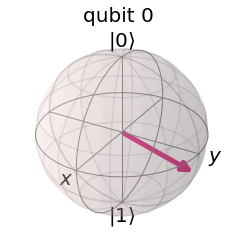

In [21]:
plot_bloch_multivector(psi)

In [22]:
init_gate=Initialize(psi)
init_gate.label='init'

In [23]:
## SETUP
qr = QuantumRegister(3)   # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical registers
crx = ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialise Alice's q0
qc.append(init_gate,[0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

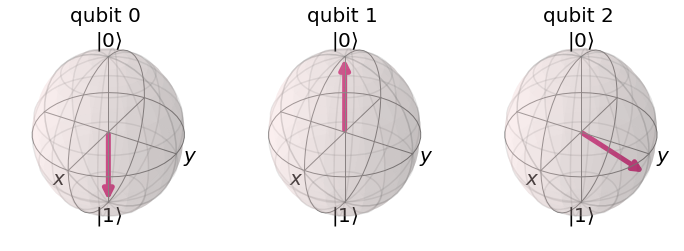

In [24]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)